### Identify Research Payment V.S. General Payment based on Medical Transaction features
The purpose of this analysis is to build a model to identify medical payment types <br>
This tesk is an aggregated workflow to build a ml process, more like in real cases <br>

The analysis including 3 parts <br>
#### 1. Understand features and select/create features
- drop features with too many missing value, taken into consideration as missing are not correlated to the final result
- winsorize / normalize variables, to avoid 
  - 1. curse of dimension when transforming categorical variable to lables 
  - 2. impact of outlier to the model, by transform the variable into normal distribution
- check data leakage, some of the feature have totally different value for Research payment v.s. General Payment. Understand how those 2 share similar features is critical to avoid data leakage

#### 2. Building model and train/select
- baseline model as tree and logistic regression to understand how features contribute to the result by looking at baseline model coefficients
- refine model by 
  - 1. grouping descriptions with regular expression to reduce dimension
  - 2. spliting some field that could be the combination of multiple dimensions
  - 3. try to find patterns in street/zip <br>
<b> select the model by <br>
  - 4. hyper parameter tuning with cross validation and random search
  - 5. ensemble (RF, Voting, XGBoosting)
    
#### 3. Findings
- amount of payment and location are the most important feature, especially if it is of higher amount and if in U.S. the probability for research funding is high
- also whether the payment is covered by insurance (covered by insurance indicate it is a general payment)
- what is payment method (cash indicate it is a general payment)
- what is the area of treatment, as the research fund is not similarly distributed as the general medical spend - for Oncology the payment is more likely to be research
- other reasons including devices, and code number for cases

#### 4. Result
- the predicted result 95% accuracy for testing set with runed tree, and 98 with XGB model

### Part 0. Sub Sampling the base
* imbalanced sample
* subsample method

In [176]:

## data processing
import pandas as pd
import numpy as np
import csv
 
import random  
import os

#plotting
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

#preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

#pipeline
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline

#model selection
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

#model
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
import xgboost as xgb
import graphviz

# model evaluation
from sklearn.metrics import precision_recall_curve, roc_curve
from sklearn.metrics import r2_score
import datetime

In [4]:

total_gen_row=11239734#sum(1 for i in open('OP_DTL_GNRL_PGYR2017_P06282019.csv'))
total_res_row=653489#sum(1 for i in open('OP_DTL_RSRCH_PGYR2017_P06282019.csv'))

total_gen_row,total_res_row
#(11239734, 653489)

nsamples_res=200000

skiprows_gen = np.sort(np.random.choice(range(1, total_gen_row), replace = False, size = total_gen_row - nsamples_res))
skiprows_res = np.sort(np.random.choice(range(1, total_res_row), replace = False, size = total_res_row - nsamples_res))


In [5]:

gen = pd.read_csv("OP_DTL_GNRL_PGYR2017_P06282019.csv", skiprows = skiprows_gen, parse_dates=['Date_of_Payment'])
res = pd.read_csv("OP_DTL_RSRCH_PGYR2017_P06282019.csv", skiprows = skiprows_res, parse_dates=['Date_of_Payment'])


C:\Users\Yilun\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (16,17,21,22,23,24,67,72) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\Yilun\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (2,5,7,8,9,10,17,18,19,20,21,22,23,24,37,38,44,45,50,52,62,67,68,69,70,71,72,73,74,75,76,79,80,81,87,88,89,90,91,92,93,94,95,96,99,100,101,107,108,109,110,111,112,113,114,115,116,119,120,121,151,156,161,162,163) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
gen.to_csv('gen.csv')

In [9]:
res.to_csv('res.csv')

In [5]:
gen=pd.read_csv('gen.csv')
res=pd.read_csv('res.csv')

C:\Users\Yilun\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (17,18,22,23,24,25,68,73) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\Yilun\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (3,6,8,9,10,11,18,19,20,21,22,23,24,25,38,39,45,46,51,53,63,68,69,70,71,72,73,74,75,76,77,80,81,82,88,89,90,91,92,93,94,95,96,97,100,101,102,108,109,110,111,112,113,114,115,116,117,120,121,122,152,157,162,163,164) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


 warnings show mixed types of data in multiple columns, which is a sign to 
    1. check the null and missing value
    2. check whether some numerical value is converted into categorical or vice versa

### Part 1. Understand Features

In [13]:
gen.shape,res.shape

((199999, 75), (199999, 176))

Feature could be grouped by feature name at the first glance
1. check data type
2. check feature unique value
3. check feature null value
4. check data leakage

In [6]:
gen['Tag']=0
res['Tag']=1

In [7]:
#combine 2 sets of data with different result to 1, leaving columns that are in common in both sets
#the common features are 66
comb=pd.concat([gen,res],axis=0,verify_integrity=False,sort=True,join="inner")
comb.shape

In [8]:
comb.shape

(399998, 66)

Create a table showing each variable''s missing ratio and unique value

In [13]:
#unique check

unique=pd.DataFrame(comb.groupby('Tag').nunique())
unique_dfT=unique.T
unique_dfT['Overall_Unique']=comb.nunique()
unique_dfT.columns=['0_unique','1_unique','Overall_Unique']

#null check
def null_check(x):
    return sum(x.isnull())

nulldf=comb.groupby('Tag').agg(null_check) 
nulldfT=nulldf.T

nulldfT.rename(columns={0: "0_Null", 1: "1_Null"},inplace=True)
nulldfT['Overall_Null_Ratio']    =nulldfT.apply(lambda x:sum(x[:2]),axis=1)/400000
nulldfT['0_Null_Ratio']    =nulldfT['0_Null']/200000
nulldfT['1_Null_Ratio']    =nulldfT['1_Null']/200000 
dfinfo=pd.concat([nulldfT,unique_dfT],axis=1) 

dfinfo.shape

pd.set_option('max_colwidth', 100)
pd.set_option('display.max_rows', 500)
dfinfo

C:\Users\Yilun\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [23]:
pd.set_option('max_colwidth', 100)
pd.set_option('display.max_rows', 500)
dfinfo

,0_Null,1_Null,Overall_Null_Ratio,0_Null_Ratio,1_Null_Ratio,0_unique,1_unique,Overall_Unique
Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Country,0.0,0.0,0.000000,0.000000,0.000000,20,18,24
Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_ID,0.0,0.0,0.000000,0.000000,0.000000,1009,562,1126
Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name,0.0,0.0,0.000000,0.000000,0.000000,1022,569,1155
Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_State,1738.0,19704.0,0.053605,0.008690,0.098520,42,35,44
Associated_Drug_or_Biological_NDC_1,53897.0,102822.0,0.391798,0.269485,0.514110,925,658,1111
Associated_Drug_or_Biological_NDC_2,161457.0,196124.0,0.893953,0.807285,0.980620,400,35,415
Associated_Drug_or_Biological_NDC_3,186352.0,199578.0,0.964825,0.931760,0.997890,258,14,268
Associated_Drug_or_Biological_NDC_4,196669.0,199902.0,0.991428,0.983345,0.999510,132,6,136
Associated_Drug_or_Biological_NDC_5,199511.0,199949.0,0.998650,0.997555,0.999745,46,4,50
Change_Type,0.0,0.0,0.000000,0.000000,0.000000,4,4,4


Criteria to drop feature
1. too much missing
all Associated_Drug_or_Biological_NDC_2 - 5
2. no overlapping value for research or general

In [14]:
# quick func to check the top in categorical data
def top_cat(X):
    l1=comb[comb['Tag']==0][X].value_counts()[:10]
    l2=comb[comb['Tag']==1][X].value_counts()[:10]
    print('gen')
    print(l1)
    print('res')
    print(l2)
    print('In common')
    print(len(set(l1.index).intersection(set(l2.index))))

In [53]:
top_cat("Associated_Drug_or_Biological_NDC_1")

gen
50458-580-30    5106
0169-4060-90    4537
00031-062-10    3713
0078-0659-20    3097
55513-710-01    2712
50458-140-30    2655
0006-0277-82    2408
0002-1433-80    2205
00597-0152-0    2194
0074-4339-02    2173
Name: Associated_Drug_or_Biological_NDC_1, dtype: int64
res
0006-3029-01    9569
62856-529-60    8506
64406-006-02    3553
0597-0140-30    2828
0169-2660-15    2751
65757-300-01    2083
0597-0152-30    1914
0069-0187-21    1788
0024-5901-00    1718
62856-710-30    1570
Name: Associated_Drug_or_Biological_NDC_1, dtype: int64
In common
0


this shows this metric highly likely leaking information or providing really distinguishable value <br>
Considering there are overlap between the 2, we might want to add it back

In [54]:
top_cat("Covered_or_Noncovered_Indicator_1")

gen
Covered        185343
Non-Covered      5078
Name: Covered_or_Noncovered_Indicator_1, dtype: int64
res
Covered        125299
Non-Covered     48416
Name: Covered_or_Noncovered_Indicator_1, dtype: int64
In common
2


In [55]:
top_cat("Product_Category_or_Therapeutic_Area_1")

gen
Diabetes                         10129
RESPIRATORY                       9173
Cardiovascular & Metabolism       7845
Immunology                        6088
CARDIOVASCULAR                    5757
NEUROSCIENCE                      5246
Endocrinology                     5144
Cardiovascular and Metabolism     4788
GASTROENTEROLOGY                  4546
DIABETES                          4251
Name: Product_Category_or_Therapeutic_Area_1, dtype: int64
res
ONCOLOGY                        17976
Nutrition and Weight Loss        8506
Oncology                         7939
DIABETES                         7699
Diabetes                         6411
Cardiology/Vascular Diseases     5854
NEUROLOGY                        5851
CNS                              3767
Immunology                       3748
CARDIOVASCULAR                   3553
Name: Product_Category_or_Therapeutic_Area_1, dtype: int64
In common
4


The above 2 is normal, no need to drop

 build a filter of thefinal columns <br>
 rule on missing value 
1. overall missing >60%
2. research or general missing >80%


In [56]:
dfinfo.columns

Index(['0_Null', '1_Null', 'Overall_Null_Ratio', '0_Null_Ratio',
       '1_Null_Ratio', '0_unique', '1_unique', 'Overall_Unique'],
      dtype='object')

In [15]:
dfinfo_1=dfinfo[(dfinfo['0_Null_Ratio']<0.8)&(dfinfo['1_Null_Ratio']<0.8)&(dfinfo['Overall_Null_Ratio']<0.6)&(dfinfo['Overall_Unique']>1)&(dfinfo['Overall_Unique']<399997)]

In [16]:
var_set_1=dfinfo_1.index

In [17]:
comb.loc[:,var_set_1].dtypes

Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Country            object
Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_ID                  int64
Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name               object
Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_State              object
Associated_Drug_or_Biological_NDC_1                                         object
Change_Type                                                                 object
Covered_Recipient_Type                                                      object
Covered_or_Noncovered_Indicator_1                                           object
Date_of_Payment                                                     datetime64[ns]
Dispute_Status_for_Publication                                              object
Form_of_Payment_or_Transfer_of_Value                                        object
Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_1                   object
Name

In [77]:
top_cat("Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_ID")

gen
100000000286    10537
100000000278     8937
100000000232     8504
100000000146     7886
100000000144     7179
100000000053     6955
100000000203     6147
100000005449     5931
100000000228     5845
100000000234     5754
Name: Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_ID, dtype: int64
res
100000000286    14400
100000000053    13319
100000000263    12007
100000000136    10836
100000000255     8724
100000000067     8723
100000000204     7754
100000000163     6681
100000000193     5899
100000010579     5474
Name: Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_ID, dtype: int64
In common
2


In [78]:
top_cat("Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_1")

gen
XARELTO      5112
Victoza      4537
FARXIGA      3713
ENTRESTO     3093
ELIQUIS      3024
JARDIANCE    2733
Prolia       2712
INVOKANA     2665
JANUVIA      2408
TRULICITY    2205
Name: Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_1, dtype: int64
res
KEYTRUDA               9569
Belviq                 8506
TECFIDERA              3553
TRADJENTA              2828
Tresiba                2751
Non-Covered Product    2508
Sentus                 2216
Vivitrol 380mg         2083
SAR231893              1950
JARDIANCE              1851
Name: Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_1, dtype: int64
In common
1


In [ ]:
# except for amount, drop those cat var who has more than 100 cont

In [18]:
var_set_2=dfinfo_1[(dfinfo_1['Overall_Unique']<100)].index

In [19]:
var_2=var_set_2.tolist()
var_2.append('Total_Amount_of_Payment_USDollars')

### Step 2. Bivariate analysis

(array([7.50000e+01, 1.64100e+03, 2.25130e+04, 1.65282e+05, 7.36010e+04,
        8.51800e+04, 4.22620e+04, 8.77900e+03, 6.31000e+02, 3.40000e+01]),
 array([-4.60517019, -2.48019474, -0.3552193 ,  1.76975614,  3.89473159,
         6.01970703,  8.14468247, 10.26965792, 12.39463336, 14.5196088 ,
        16.64458425]),
 <a list of 10 Patch objects>)

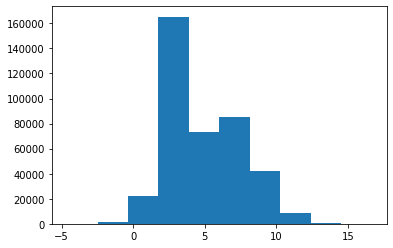

In [10]:
#first check the cont var : payment dollar
plt.hist(np.log(comb.Total_Amount_of_Payment_USDollars))

In [11]:
comb.groupby('Tag').mean()['Total_Amount_of_Payment_USDollars']

Tag
0     311.429872
1    7634.153894
Name: Total_Amount_of_Payment_USDollars, dtype: float64

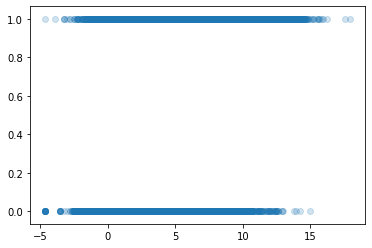

In [98]:
plt.scatter(np.log(comb.Total_Amount_of_Payment_USDollars),comb.Tag,alpha=0.2)

In [ ]:
# then check categorical variables

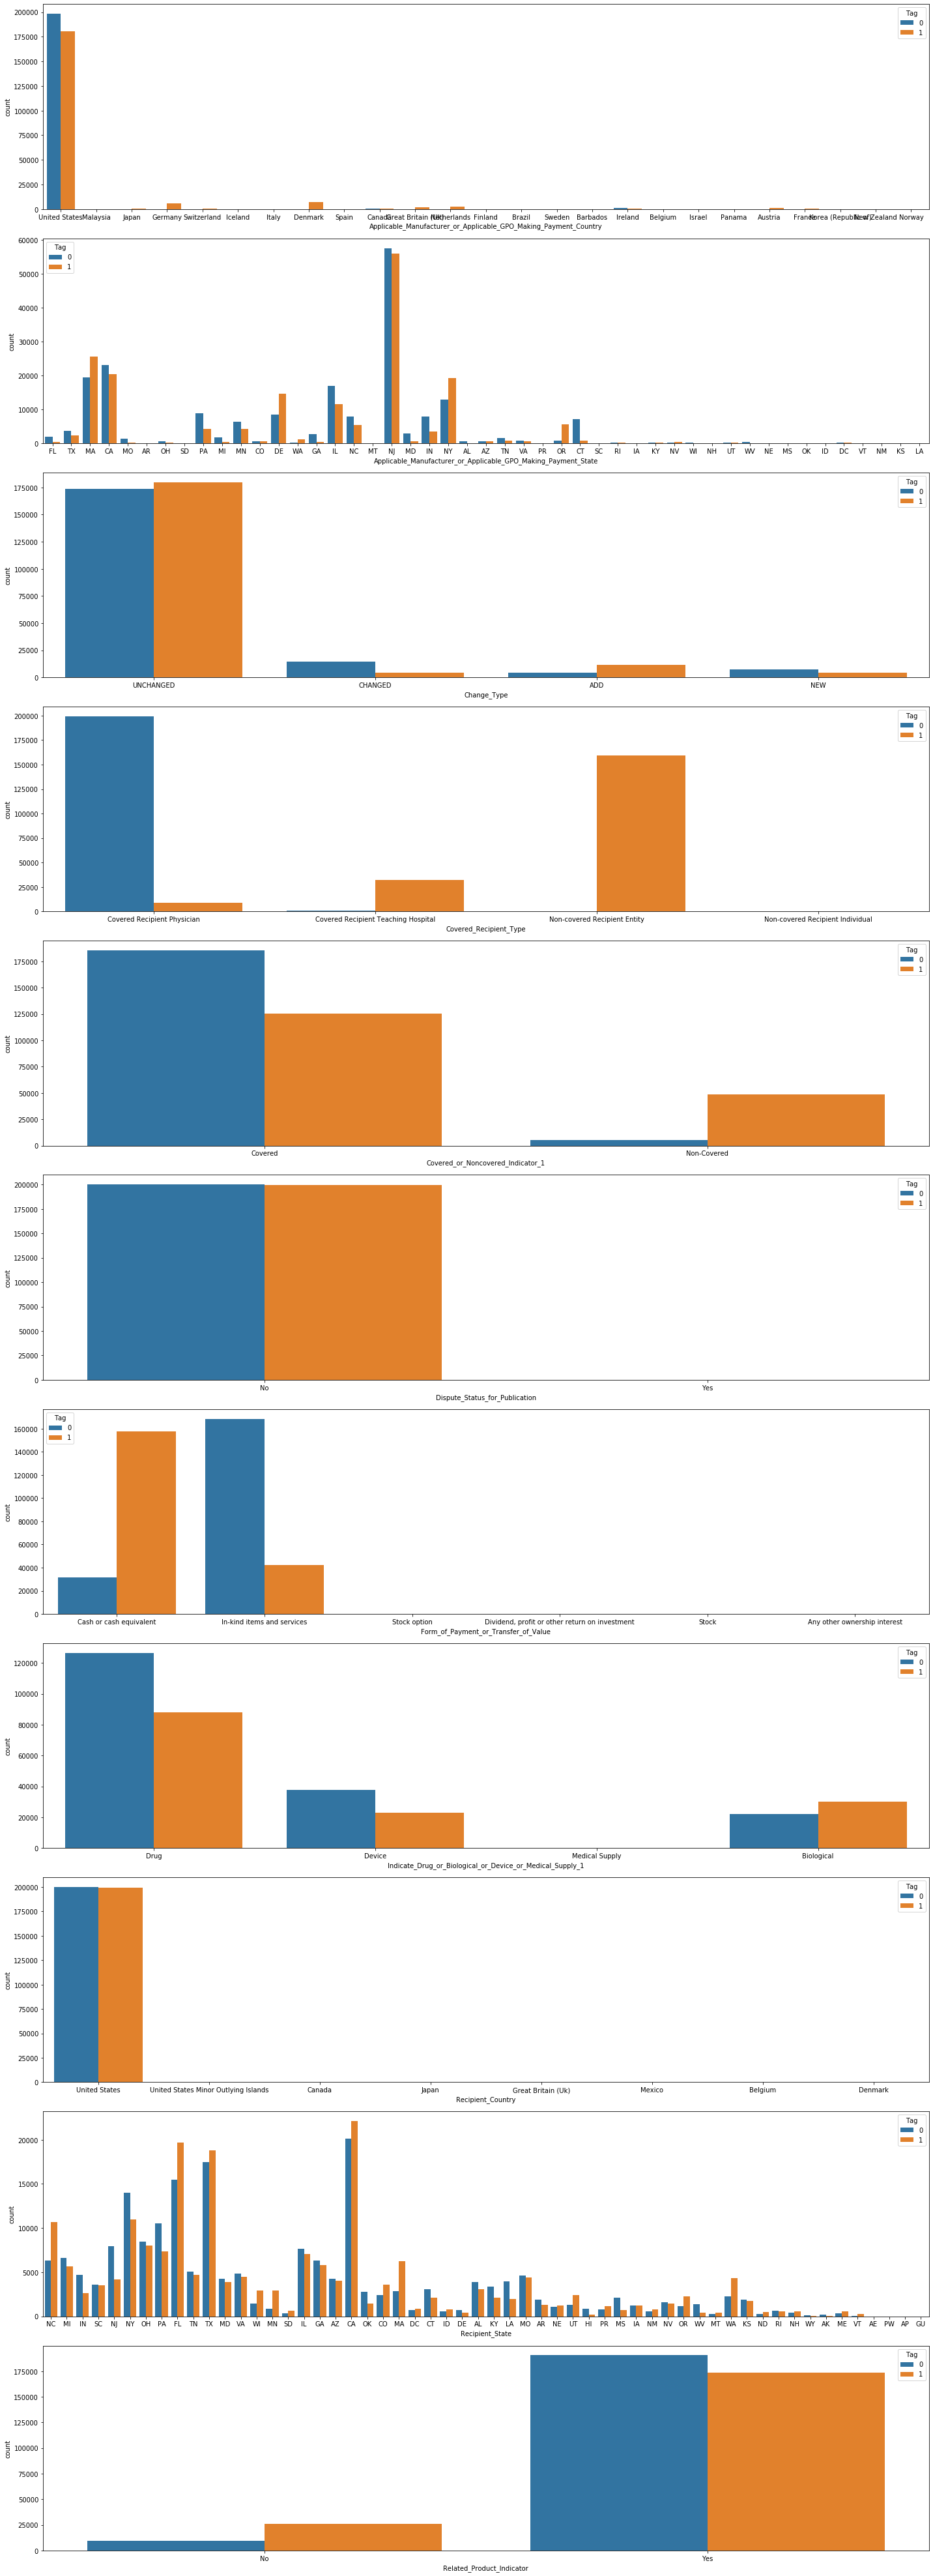

In [109]:
fig, ax = plt.subplots(  len(var_2[:-1]), figsize = (20, len(var_2[:-1])*5))
i=0
for v in var_2[:-1]:
    sns.countplot(v, hue='Tag', data = comb, ax = ax[i])
    i+=1

plt.tight_layout()

change type is a highly likely variable to be leaking result
need to be dropped

In [36]:
var_2

['Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Country',
 'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_State',
 'Change_Type',
 'Covered_or_Noncovered_Indicator_1',
 'Dispute_Status_for_Publication',
 'Form_of_Payment_or_Transfer_of_Value',
 'Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_1',
 'Recipient_Country',
 'Recipient_State',
 'Related_Product_Indicator',
 'Total_Amount_of_Payment_USDollars']

In [32]:
var_2.remove('Covered_Recipient_Type')


### Step 3. Modeling